# Waveguide Coupling Simulation with Port Bending

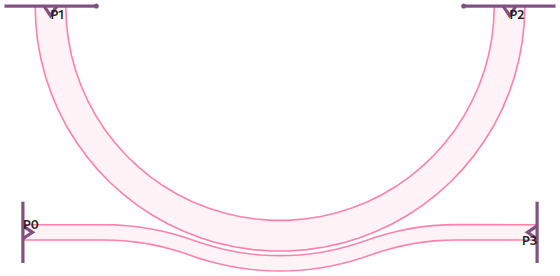

In this notebook, we will:

- Create a waveguide coupled to a multi-mode waveguide, using a pulley coupler.
- Incorporate port bending radius into the simulation.
- Perform an S-matrix simulation and calculate the coupling efficiency.

In [1]:
import numpy as np
import photonforge as pf
import tidy3d as td
from matplotlib import pyplot as plt

td.config.logging_level = "ERROR"

We will use the [SiEPIC OpenEBL](https://siepic.ca/openebl/) through the `siepic_forge` module. So, we set up the default photonic technology, simulation mesh refinement, and define the wavelength range for our simulations from 1.53 µm to 1.57 µm.

In [2]:
import siepic_forge as siepic

tech = siepic.ebeam()

pf.config.default_technology = tech
pf.config.default_mesh_refinement = 12.0
wavelengths = np.linspace(1.53, 1.57, 51)

Next, we define the waveguide ports for our simulation. We start by using a default `siepic` waveguide port specification ("TE_1550_500"). Then, we create a new custom [port specification](../_autosummary/photonforge.PortSpec.rst) for a wider multi-mode waveguide. 

The new multi-mode waveguide (`port_spec_mm`) has the following properties:

- Port width: 3 µm 
- Number of modes: 2 (multi-mode)
- Target effective index (`target_neff`): 3.5
- Port limits in the z direction: (-1, 1.22)

In [3]:
# The default narrow waveguide
port_spec = tech.ports["TE_1550_500"]

# You can create new port spec for a wider multi-mode waveguide like this
mm_wg_width = 1
port_spec_mm = pf.PortSpec(
    description="Multi mode strip",
    width=3,
    num_modes=2,
    target_neff=3.5,
    limits=(-1, 1.22),
    path_profiles=[(mm_wg_width, 0, (1, 0))],
)

After defining a new port, it's important to verify that its mode properties are correctly computed. Specifically, we must confirm that the mode field fully decays at the port boundaries. If the mode hasn't adequately decayed, it is necessary to increase the `width` and `limits` parameters of the port.

We first calculate the mode at the default "TE_1550_500" port as a benchmark, and then we compare it with the modes calculated at the newly defined port.


### Mode for the single mode port

First, we calculate the guided modes at port "TE_1550_500" using a dedicated mode solver. The calculation is performed at the reference wavelength of 1.55 µm, with a refined mesh (`mesh_refinement=40`) to achieve accurate mode profiles. 
The resulting mode properties are presented clearly in a pandas data frame for convenient inspection.

In [4]:
mode_solver = pf.port_modes(
    port_spec,
    frequencies=[pf.C_0 / 1.55],
    mesh_refinement=40,
    group_index=True,
)

mode_solver.data.to_dataframe()

Loading cached simulation from .tidy3d/pf_cache/EVN/ms_info-WOMORNVZ37RKO34T4GWITOOMRDRRKASHOI7KZWDMQI3EEJAAQ5OA.json.


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  2.442854    0.0          0.983471   

                         wg TE fraction  wg TM fraction  mode area  \
f            mode_index                                              
1.934145e+14 0                 0.763901        0.817692   0.191377   

                         group index  dispersion (ps/(nm km))  
f            mode_index                                        
1.934145e+14 0              4.186981              -735.555905


Here, we visualize the electric field (E-field) distribution of the fundamental mode (mode index 0) at the port "TE_1550_500" for the reference wavelength of 1.55 µm. 


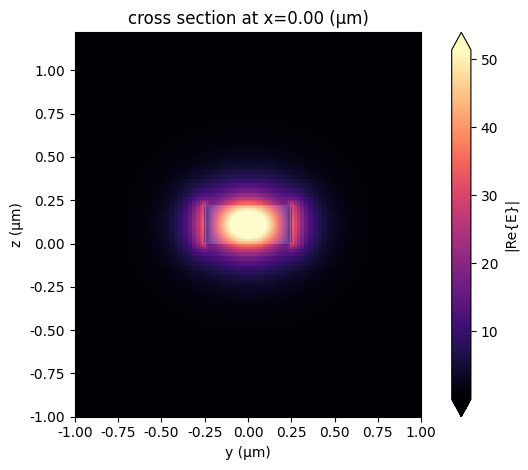

In [5]:
_ = mode_solver.plot_field("E", mode_index=0, f=pf.C_0 / 1.55)

### Modes for the multi-mode port

Similarly, we compute the guided modes at the multi-mode port.


In [6]:
mode_solver_mm = pf.port_modes(
    port_spec_mm,
    frequencies=[pf.C_0 / 1.55],
    mesh_refinement=40,
    group_index=True,
)

mode_solver_mm.data.to_dataframe()

Loading cached simulation from .tidy3d/pf_cache/FRC/ms_info-TKUYUOES7FLZ7XGPJ64B3NR3Z7BBROSW6JSCOXSV57JF6WEFDTQQ.json.


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  2.742665    0.0          0.998373   
             1                 1.55  2.416488    0.0          0.988914   

                         wg TE fraction  wg TM fraction  mode area  \
f            mode_index                                              
1.934145e+14 0                 0.929505        0.804911   0.234526   
             1                 0.738769        0.835664   0.333227   

                         group index  dispersion (ps/(nm km))  
f            mode_index                                        
1.934145e+14 0              3.828065             -1996.508886  
             1              4.281732                26.269854

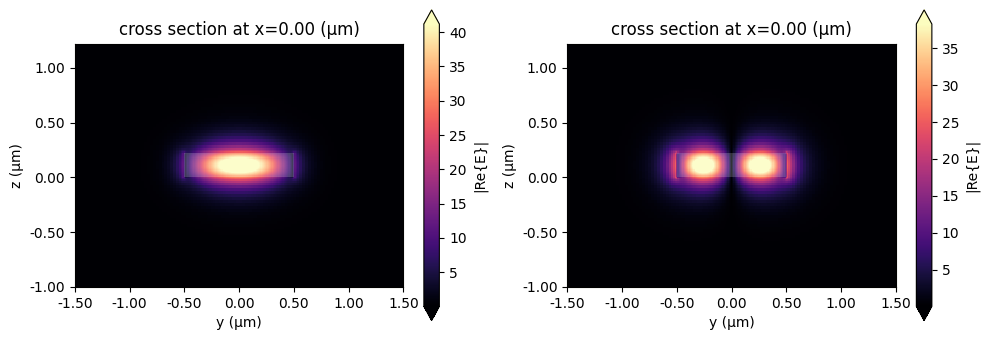

In [7]:
_, ax = plt.subplots(1, 2, figsize=(10, 3.5), tight_layout=True)
_ = mode_solver_mm.plot_field("E", mode_index=0, f=pf.C_0 / 1.55, ax=ax[0])
_ = mode_solver_mm.plot_field("E", mode_index=1, f=pf.C_0 / 1.55, ax=ax[1])

It is evident that the fields have fully decayed at the port boundaries, confirming that the current port dimensions are sufficient (you can set `scale="dB"` in the plots to confirm the decay).


### Defining the Pulley Coupler Component

We define the function `make_pulley_coupler` to construct a photonic pulley coupler component. This function generates a coupler comprising a ring waveguide coupled to a bus waveguide. Parameters such as the ring radius, coupling angle, and gap size between waveguides can be customized. Additionally, the waveguide port specifications are defined through the inputs `port_spec_bus` and `port_spec_ring`.

In [8]:
def make_pulley_coupler(
    ring_radius=7.5,
    coupling_angle=20,
    gap=0.15,
    port_spec_bus=port_spec,
    port_spec_ring=port_spec_mm,
):
    # Error check
    if coupling_angle > 70:
        raise ValueError("Coupling angle cannot be greater than 70 degrees.")

    if isinstance(port_spec_bus, str):
        port_spec_bus = pf.config.default_technology.ports[port_spec_bus]

    if isinstance(port_spec_ring, str):
        port_spec_ring = pf.config.default_technology.ports[port_spec_ring]

    c = pf.Component("Pulley Coupler")

    # Extract waveguide widths from port specifications
    bus_width = port_spec_bus.path_profiles[0][0]  # Bus waveguide width (single-mode)
    ring_width = port_spec_ring.path_profiles[0][0]  # Ring waveguide width (multimode)

    # Bus waveguide bending radius calculation
    bus_radius = ring_radius + ring_width / 2 + gap + bus_width / 2

    # Calculate input coordinates for bus waveguide
    x_in = -bus_radius * np.sin(np.radians(coupling_angle))
    y_in = -bus_radius * np.cos(np.radians(coupling_angle))

    # Define bus input path based on coupling angle
    if coupling_angle < 30:
        bus = pf.Path((-bus_radius, 2 * y_in + bus_radius), bus_width)
        bus.segment((2 * x_in, 2 * y_in + bus_radius))
        bus.turn(-coupling_angle, radius=bus_radius)
        bus.turn(2 * coupling_angle, radius=bus_radius)
        bus.turn(-coupling_angle, radius=bus_radius)
        bus.segment((bus_radius, 2 * y_in + bus_radius))
    else:
        bus = pf.Path((2 * x_in, 2 * y_in + bus_radius), bus_width)
        bus.turn(-coupling_angle, radius=bus_radius)
        bus.turn(2 * coupling_angle, radius=bus_radius)
        bus.turn(-coupling_angle, radius=bus_radius)

    # Create ring waveguide
    ring = pf.Circle(
        radius=ring_radius + ring_width / 2,
        inner_radius=ring_radius - ring_width / 2,
        sector=(-180, 0),
    )

    # Add waveguide elements to the component
    c.add("Si", bus, ring)

    # Detect and add ports
    c.add_port(c.detect_ports([port_spec_bus, port_spec_ring]))
    assert len(c.ports) == 4, "Port detection failed: expected exactly 4 ports."

    # Assign a bend radius to both ring ports
    c["P1"].bend_radius = ring_radius
    c["P2"].bend_radius = -ring_radius

    # Finally, add a Tidy3D model to calculate S parameters.
    c.add_model(pf.Tidy3DModel(), "Tidy3D")

    return c


# Create coupler with specified ring radius
ring_radius = 7.5
coupler = make_pulley_coupler(ring_radius=ring_radius)
coupler

To verify the created component, we print out the available ports using a simple loop. Each port's key and corresponding properties are displayed, allowing easy inspection and verification before simulation or further layout generation.

In [9]:
for name, port in coupler.ports.items():
    print(f"{name}: {port}")

P3: Port at (8.4, -7.387) at 180 deg with spec "Strip TE 1550 nm, w=500 nm"
P2: Port at (7.5, 0) at 270 deg with spec "Multi mode strip"
P1: Port at (-7.5, 0) at 270 deg with spec "Multi mode strip"
P0: Port at (-8.4, -7.387) at 0 deg with spec "Strip TE 1550 nm, w=500 nm"


It is important to note that the ring ports are set with a proper bend radius that follows the ring curvature.
If we inspect the modes at the port and compare to the ones calculated previously directly from the multi-mode port specification (without bend radius), we can clearly see the differences:

Loading cached simulation from .tidy3d/pf_cache/CH4/ms_info-HPBIPSE7M77FTYREFHXAXFSYUV43NI2LI7KCMY3AIKBYB4PDHLUA.json.


wavelength     n eff         k eff  loss (dB/cm)  \
f            mode_index                                                     
1.934145e+14 0                 1.55  2.756323 -1.333296e-08     -0.004694   
             1                 1.55  2.411111  5.603837e-07      0.197310   

                         TE (Ex) fraction  wg TE fraction  wg TM fraction  \
f            mode_index                                                     
1.934145e+14 0                   0.997761        0.921468        0.805626   
             1                   0.988590        0.741904        0.835576   

                         mode area  group index  dispersion (ps/(nm km))  
f            mode_index                                                   
1.934145e+14 0            0.227212     3.880276             -1208.413273  
             1            0.325635     4.258664              1260.952981

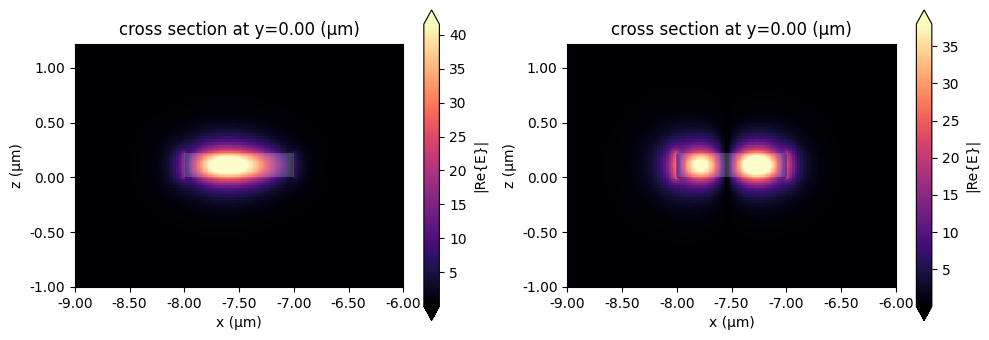

In [10]:
mode_solver_p1 = pf.port_modes(
    coupler["P1"],
    frequencies=[pf.C_0 / 1.55],
    mesh_refinement=40,
    group_index=True,
)

_, ax = plt.subplots(1, 2, figsize=(10, 3.5), tight_layout=True)
_ = mode_solver_p1.plot_field("E", mode_index=0, f=pf.C_0 / 1.55, ax=ax[0])
_ = mode_solver_p1.plot_field("E", mode_index=1, f=pf.C_0 / 1.55, ax=ax[1])

mode_solver_p1.data.to_dataframe()

### Coupling Calculation

Next, we compute the S-parameters (scattering parameters) specifically for the input port "P0". This calculation characterizes the coupler's transmission and reflection behavior over the previously defined wavelength range.

In [11]:
s_matrix = coupler.s_matrix(pf.C_0 / wavelengths, model_kwargs={"inputs": ["P0"]})

Loading cached simulation from .tidy3d/pf_cache/H6C/fdtd_info-U5NB45NWETBHLHE7NAA4ZTLOYHOCBCWOR5RB3RWYKUYR6MLP5OLA.json.


Progress: 100% 


We visualize the computed S-parameters using [plot_s_matrix](../_autosummary/photonforge.plot_s_matrix.rst). We observe approximately 4.2% power transfer from the bus waveguide into the ring waveguide's fundamental mode and about 1.3% coupling into the second mode.

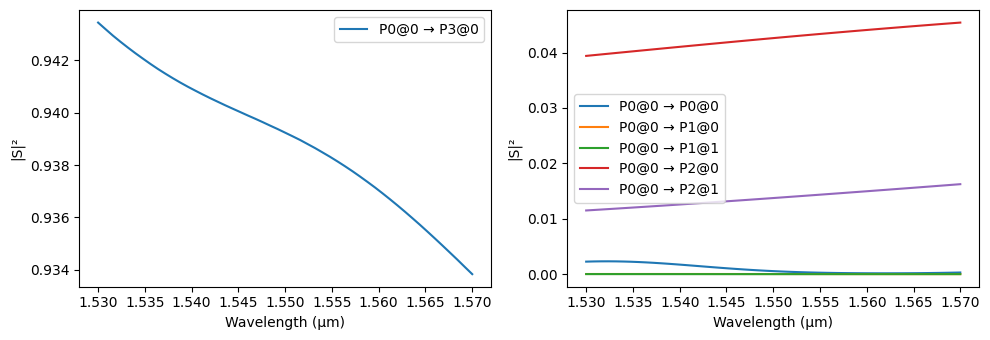

In [12]:
_ = pf.plot_s_matrix(s_matrix)

For comparison, we can remove the bend radius from the ring ports and see the changes in coupling:

In [13]:
straight_port_coupler = make_pulley_coupler(ring_radius=ring_radius)
straight_port_coupler["P1"].bend_radius = 0
straight_port_coupler["P2"].bend_radius = 0
straight_port_coupler

Loading cached simulation from .tidy3d/pf_cache/H6C/fdtd_info-KF5HYRHCGEOSPGJZ4OFSPZ3AS44RBOVUR5L63HJ7INJIWOVVDGHA.json.


Progress: 100% 


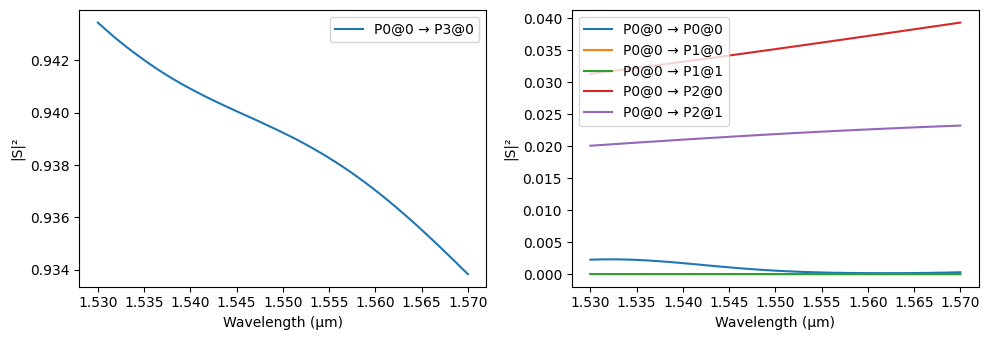

In [14]:
straight_port_s_matrix = straight_port_coupler.s_matrix(
    pf.C_0 / wavelengths, model_kwargs={"inputs": ["P0@0"]}
)

_ = pf.plot_s_matrix(straight_port_s_matrix)

We can plot both results together to see the differences more clearly:

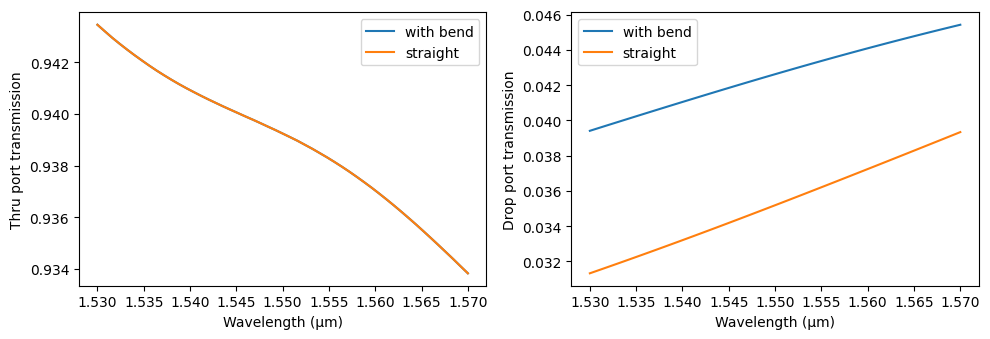

In [15]:
_, ax = plt.subplots(1, 2, figsize=(10, 3.5), tight_layout=True)

# Through port comparison
thru_bend = np.abs(s_matrix["P0@0", "P3@0"]) ** 2
thru_straight = np.abs(straight_port_s_matrix["P0@0", "P3@0"]) ** 2

ax[0].plot(wavelengths, thru_bend, label="with bend")
ax[0].plot(wavelengths, thru_straight, label="straight")

# Through port comparison
drop_bend = np.abs(s_matrix["P0@0", "P2@0"]) ** 2
drop_straight = np.abs(straight_port_s_matrix["P0@0", "P2@0"]) ** 2

ax[1].plot(wavelengths, drop_bend, label="with bend")
ax[1].plot(wavelengths, drop_straight, label="straight")

ax[0].set(xlabel="Wavelength (μm)", ylabel="Thru port transmission")
ax[1].set(xlabel="Wavelength (μm)", ylabel="Drop port transmission")

ax[0].legend()
_ = ax[1].legend()

As expected, the transmitted power to port "P3" (thru port) remains unchanged, since no bending adjustments were applied to this port.
However, when bending effects are removed from port "P2" (drop port), we observe a reduction in the coupled power to that port mode.